###### Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import math
from jax import numpy as jnp, jacfwd
%load_ext autoreload
%autoreload 2
plt.style.use('seaborn-darkgrid')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


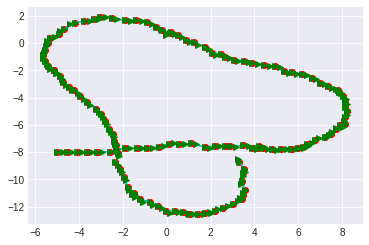

In [49]:
def draw(X, Y, THETA, file_name=None):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25 * np.cos(THETA[i]) + X[i]
        y2 = 0.25 * np.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')
    
    if file_name is not None:
        plt.savefig(file_name)
    else:
        plt.plot()

data_file = open('../data/edges.txt')
data = data_file.readlines()
 
initial = data[0].split(' ')
 
X = [float(initial[2])]
Y = [float(initial[3])]
THETA = [float(initial[4])]
 
for i in range(1, len(data)):
    line = data[i].split(' ')
 
    if line[0] == "FIX":
        break
 
    dx = float(line[3])
    dy = float(line[4])
    dtheta = float(line[5])
 
    X.append(X[-1] + dx * math.cos(THETA[-1]) - dy * math.sin(THETA[-1]))
    Y.append(Y[-1] + dy * math.cos(THETA[-1]) + dx * math.sin(THETA[-1]))
    THETA.append(THETA[-1] + dtheta)
 
draw(X, Y, THETA)

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [51]:
get_next_pose = lambda initial, change: np.array(
    [
        initial[0] + change[0] * np.cos(initial[2]) - change[1] * np.sin(initial[2]),
        initial[1] + change[1] * np.cos(initial[2]) + change[0] * np.sin(initial[2]),
        initial[2] + change[2],
    ]
)

get_next_pose_jnp = lambda initial, change: jnp.array(
    [
        initial[0] + change[0] * jnp.cos(initial[2]) - change[1] * jnp.sin(initial[2]),
        initial[1] + change[1] * jnp.cos(initial[2]) + change[0] * jnp.sin(initial[2]),
        initial[2] + change[2],
    ]
)

In [52]:
# Data loading

initial_poses = []
od_constraints = []
loop_constraints = []
 
data_file = open("../data/noisy.g2o")
 
for line in data_file.readlines():
    params = line[:-1].split(" ")
 
    if len(params) < 5:
        continue
 
    if params[0] == "VERTEX_SE2":
        initial_poses.append(np.array([float(params[2]), float(params[3]), float(params[4])]))
        # n * 3
    else:
        pose_start = int(params[1])
        pose_end = int(params[2])
 
        formatted_params = [
            [
                pose_start,
                pose_end,
            ],
            [
                float(params[3]),
                float(params[4]),
                float(params[5]),
            ],
        ]
 
        if pose_end == pose_start + 1:
            od_constraints.append(formatted_params)
        else:
            loop_constraints.append(formatted_params)
 
initial_poses = np.array(initial_poses)


In [41]:
constraints = []
constraints.extend(od_constraints)
constraints.extend(loop_constraints)
initial_state = initial_poses.reshape(-1,1)
n_poses = initial_poses.shape[0]
n_constraints = len(constraints)
f_shape = (n_constraints * 3 + 3, 1)
j_shape = (f_shape[0], initial_state.shape[0])

In [42]:
def f_raw(state):
    poses = state.reshape(-1,3)
    fixed_pose = initial_poses[0]
    f = []
 
    for constraint in constraints:
        pose_start = constraint[0][0]
        pose_end = constraint[0][1]
 
        diff = get_next_pose(poses[pose_start], constraint[1]) - poses[pose_end]
        f.extend(diff)
 
    # initial position
    f.extend(poses[0] - fixed_pose)
    return f


In [53]:
def jax_f(state):
    poses = state.reshape(-1,3)
    fixed_pose = initial_poses[0]
    f = []
 
    for constraint in constraints:
        pose_start = constraint[0][0]
        pose_end = constraint[0][1]
 
        diff = get_next_pose_jnp(poses[pose_start], constraint[1]) - poses[pose_end]
        f.extend(diff)
 
    # initial position
    f.extend(poses[0] - fixed_pose)
    return f
def f(state):
    return np.array(f_raw(state)).reshape(-1,1)

In [54]:
def get_info_mat(od_info=500, loop_info=700, fix_info=1000):
    n_od = 3*len(od_constraints)
    n_loop = 3*len(loop_constraints)
    info_mat = np.eye(f_shape[0])
    info_mat[:n_od,:n_od] = od_info*np.eye(n_od)
    info_mat[n_od:n_od + n_loop,n_od:n_od+ n_loop] = loop_info*np.eye(n_loop)
    info_mat[-3:,-3:] = fix_info*np.eye(3)
    return info_mat

In [55]:
def jac(state:np.ndarray):
    J = np.zeros(j_shape)
    for i, constraint in enumerate(constraints):
        pose_start = constraint[0][0]
        pose_end = constraint[0][1]
        theta_start = state[3*pose_start+2]
        
        # x constraint
        J[3*i, 3 * pose_start] = 1 
        J[3*i, 3 * pose_end] = -1 
        J[3*i, 3 * pose_start + 2] = -constraint[1][0]*np.sin(theta_start) - constraint[1][1]*np.cos(theta_start) 
        
        # y constraint
        J[3*i + 1, 3 * pose_start + 1] = 1 
        J[3*i + 1, 3 * pose_end + 1] = -1 
        J[3*i + 1, 3 * pose_start + 2] = -constraint[1][1]*np.sin(theta_start) + constraint[1][0]*np.cos(theta_start) 
        
        # theta constraint
        J[3*i+2,3*pose_start+2] = 1
        J[3*i+2,3*pose_end+2] = -1
   
    # fixed poses
    J[-3,0] = 1
    J[-2,1] = 1
    J[-1,2] = 1
    return J

In [56]:
jac_jax = jacfwd(jax_f)

In [57]:
J_jax = jac_jax(initial_poses.reshape(-1))
J = jac(initial_poses.reshape(-1))

In [58]:
def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    # jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")

In [60]:
# Comparing 2 jacobians
frobNorm(J, J_jax)

Frobenius norm between mat1 and mat2 is: 8.390286438952899e-07


In [61]:
from optimizer import Optimizer

In [105]:
# Reduce information of theta edges
# info_mat = get_info_mat(20,700,1000)
# theta_info_ratio = .5
# for i in range(info_mat.shape[0]):
#     if i % 3 == 2:
#         info_mat[i,i] *= theta_info_ratio
        
# info_mat[-1,-1] = 1000

In [115]:
info_mat = get_info_mat(20,700,1000)

In [116]:
solver = Optimizer(f, jac, initial_state, info_mat, algo='LM', lm_lambda=1,n_iter=100)

INFO: Using ALGO: LM
INFO Initial Error: 639371.6381937417


In [117]:
solver.optimize()

Iteration: 0 / 100
Loss: 639371.6381937417
LM: Update Accepted
Iteration: 1 / 100
Loss: 103336.34256273886
LM: Update Accepted
Iteration: 2 / 100
Loss: 848.784075990026
LM: Update Accepted
Iteration: 3 / 100
Loss: 678.970149853822
LM: Update Rejected
LM: Update Accepted
Iteration: 5 / 100
Loss: 48.701909800130956
LM: Update Rejected
LM: Update Accepted
Iteration: 7 / 100
Loss: 41.42536030567381
LM: Update Rejected
LM: Update Accepted
Iteration: 9 / 100
Loss: 30.845344788585358
LM: Update Rejected
LM: Update Accepted
Iteration: 11 / 100
Loss: 24.540289996469298
LM: Update Rejected
LM: Update Accepted
Iteration: 13 / 100
Loss: 21.54851330554379
LM: Update Rejected
LM: Update Accepted
Iteration: 15 / 100
Loss: 20.20195203189421
LM: Update Rejected
LM: Update Accepted
Iteration: 17 / 100
Loss: 19.638173417017477
LM: Update Rejected
LM: Update Accepted
Iteration: 19 / 100
Loss: 19.41267435467436
LM: Update Accepted
Iteration: 20 / 100
Loss: 19.379712461290143
LM: Update Accepted
Iteration: 

In [118]:
def draw_final(state):
    final_poses = state.reshape(-1,3)
    draw(final_poses[:,0], final_poses[:,1], final_poses[:,2])

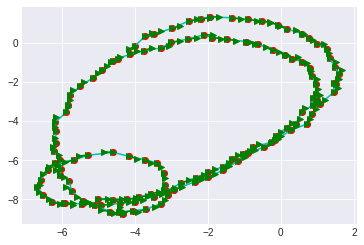

In [119]:
draw_final(solver.get_current())

```
Note: Using 20, 700, 1000 as info matrix values
```

#### Experimentation for info matrix
We did a lot of experimentation with info matrix.

- We first tried with value 500, 700, 1000: Error was about 444
- After that in order to get some idea of how the matrix should be, we first tried random numbers but to our surprise, each one of that were giving the exact same plot. So we decided to first try everything we can therefore we created a script to try for all info matrices with value: 
    - Fixed: 1000, 2000, 3000, 5000, 10000
    - Odometery: 100 -> Fixed with stride 50
    - Loop : Odometery + 50 -> Fixed with stride 50
Using a python script and made it ran 1 whole night. 
The result of it was quite surprising, **ALL** the plots had similar path as we achieved with the `500,700,1000` ({link}). We were confused on what to do. (We also did thought that our code was wrong for some time, but we thoroughlt debugged it and there were no issues.

- To move ahead we thought of seeing the optmized graph in `g2o_viewer`. <br />
<img src="./misc/1000_700_20_g2o.png" alt="drawing" width="300"/> <br>
This explained a lot to us. As you can see, the loop constraint are right and below. This our understanding why are we getting a plot like this:
    - The path got shifted below on the top due to increasing and faulty $ \theta $ values (this is again verified as the path is tilted to up on the right (increasing $\theta$), now as to get the loop constraint satisfied it needs to go up and join back to the line below, therefore we see a loop on the left. The only thing to correct the path was that it was not pushed so down (in the top line) and hence there wouldn't have been a loop required to match loop constraint. -> **The path has got into a local minima**

- After this we tried to reduce info value of $ \theta $ edges, in hope it would improve something, but it was still the same <br >
<img src="./misc/theta_small.png" alt="drawing" width="300"/> <br>

- We tried to remove the loop from left so that optimization doesn't get stuck in local minima. We tried various info mats with low odometery so that loop couldn't occur, but it occured. The reason behind that we think is that our initialization was created using faulty theta and therefore we were not able to get to global minima. To tackle this we could use Vision to get poses from other ways also hence making a better initialization 

- We tried a wierd thing also, we gave more weightage to odometery (to avoid the loop at the right), and this gave a good result, but error was high due to loop not completing (info values: `500,1,1000`) <br>
<img src="./misc/1000_1_500.png" alt="drawing" width="300"/> <br>

At the end we used info mat `20,700,1000` as it was quite less error (19) and good enough trajectory


## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

#### 2
The optmization reduces the error and for our case it was sticking into local minima (due to loop getting created on the right). Initialy plot used to get very bad but slowly it would go to a decent enough path

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [120]:
poses = solver.get_current().reshape(-1,3)
file = open('../data/optmised_1000_700_20.g2o', 'w')
for i, pose in enumerate(poses):
    file.write(f"VERTEX_SE2 {i} {pose[0]} {pose[1]} {pose[2]}\n")
    
for constraint in od_constraints:
    file.write(f"EDGE_SE2 {constraint[0][0]} {constraint[0][1]} {constraint[1][0]} {constraint[1][1]} {constraint[1][2]} 500 0 0 500 0 500\n")
    
for constraint in loop_constraints:
    file.write(f"EDGE_SE2 {constraint[0][0]} {constraint[0][1]} {constraint[1][0]} {constraint[1][1]} {constraint[1][2]} 700 0 0 700 0 700\n")

file.write("FIX 0")
file.close()

In [122]:
np.save('jac.npy', jac(initial_state))